Cross Validation Results:
Mean F1 Score:       0.820971641411915
Mean Recall Score:   0.800803957946815
Mean Precision:      0.8429208350750905

Correlations:
V14              0.218827
V4               0.125373
V10              0.122809
V17              0.091997
V12              0.080725
V11              0.072277
V16              0.055421
V3               0.046209
V7               0.031111
V2               0.025350
V9               0.016646
V8               0.012569
V21              0.011177
V18              0.009891
scaled_amount    0.007805
V5               0.007520
V1               0.007032
V19              0.006306
V6               0.006223
V13              0.005890
V20              0.004881
scaled_time      0.004803
V15              0.004639
V26              0.004622
V23              0.004069
V28              0.003663
V22              0.003335
V27              0.003100
V25              0.002922
V24              0.002810
dtype: float64

Final Model Evaluation:
Confusion Matrix: 
[[

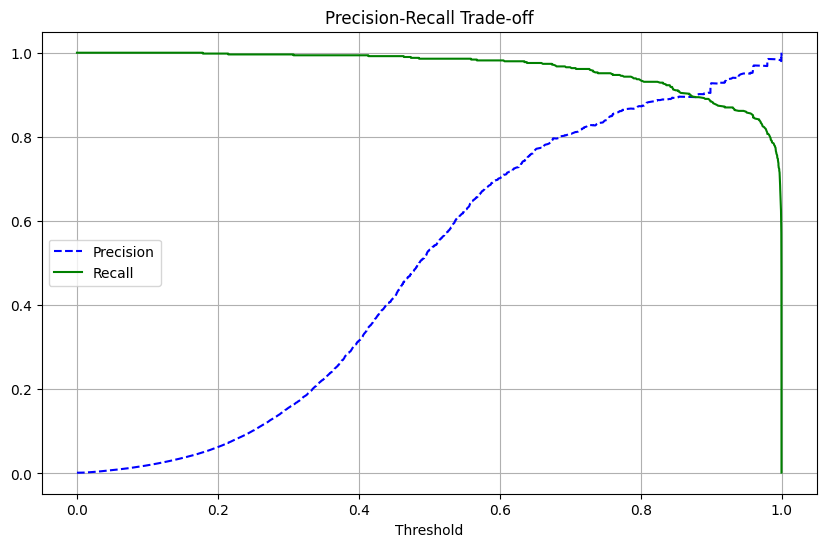

In [9]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import numpy as np


df = pd.read_csv("creditcard.csv")

scaler = StandardScaler()

df['scaled_amount'] = scaler.fit_transform(df[['Amount']])
df['scaled_time'] = scaler.fit_transform(df[['Time']])

X = df.drop(['Time', 'Amount','Class'], axis=1)
y = df['Class']

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = []
recall_scores = []
precision_scores = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    smote = SMOTE(sampling_strategy='minority')
    X_train, y_train = smote.fit_resample(X_train, y_train)

    model = RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    
    y_prob = model.predict_proba(X_test)[:, 1]
    threshold = 0.80
    new_y_pred = (y_prob >= threshold).astype(int)

    f1_scores.append(f1_score(y_test, new_y_pred))
    recall_scores.append(recall_score(y_test, new_y_pred))
    precision_scores.append(precision_score(y_test, new_y_pred))

print("Cross Validation Results:")
print("Mean F1 Score:      ", np.mean(f1_scores))
print("Mean Recall Score:  ", np.mean(recall_scores))
print("Mean Precision:     ", np.mean(precision_scores))

smote = SMOTE(sampling_strategy='minority')
X_new, y_new = smote.fit_resample(X, y)

final_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_new, y_new)

importances = final_model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns)
print("\nCorrelations:")
print(feature_importances.sort_values(ascending=False))

y_prob_final = final_model.predict_proba(X)[:, 1]
threshold = 0.80
y_pred_final = (y_prob_final >= threshold).astype(int)

print("\nFinal Model Evaluation:")

cm = confusion_matrix(y, y_pred_final)
print("Confusion Matrix: ")
print(cm)

accuracy = accuracy_score(y, y_pred_final)
print("Accuracy: ", accuracy)

precision = precision_score(y, y_pred_final)
print("Precision: ", precision)

recall = recall_score(y, y_pred_final)
print("Recall: ", recall)

f1 = f1_score(y, y_pred_final)
print("F1-Score: ", f1)

fpr, tpr, _ = roc_curve(y, y_prob_final)
roc_auc = auc(fpr, tpr)
print("ROC AUC: ", roc_auc)  

y_scores = model.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y, y_prob_final)
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.title("Precision-Recall Trade-off")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.grid()
plt.show()